# We can look at the trajectories of both the weights and activity in phase space

Because we allow negative activity, we can characterise both the weight and activity profiles just in terms of their sinusoidal amplitude - first Fourier mode.

Therefore, we can look at the trajectory of both simultaneously in 2D phase space.

In [1]:
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable

def roll_matrix_rows(matrix, roll_amounts):
	'''roll each row of a 2D matrix by an independent amount, as specified in `roll_amounts`.'''
	matrix_rolled = matrix[:, [*range(matrix.shape[1]),*range(matrix.shape[1]-1)]].copy()
	stride_0, stride_1 = matrix_rolled.strides
	num_cols = matrix.shape[1]
	result = numpy.lib.stride_tricks.as_strided(matrix_rolled, (*matrix.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[np.arange(matrix.shape[0]), (num_cols-roll_amounts) % num_cols]

In [2]:
profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_spectrum = lambda fourier_spectrum: np.fft.ifft(fourier_spectrum).real

def fill_fourier_modes_up_to_N(last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements up to the `last_fourier_mode` filled with ones.
	
	`last_fourier_mode=0` corresponds to just the DC component being filled.
	
	For higher Fourier modes both the positive and negative frequency components are filled.
	
	eg. `fill_fourier_modes_up_to_N(1, 4) = [1,1,0,1]`
	'''
	assert last_fourier_mode <= period//2+1, f'last fourier mode of {last_fourier_mode} not possible with discrete Fourier vector of length {period}'
	half_fourier_vector = np.zeros(period//2+1)
	half_fourier_vector[:last_fourier_mode+1] = 1
	return np.hstack((half_fourier_vector, np.flip(half_fourier_vector[1:-1])))

def fill_fourier_modes_up_to_N_without_DC(last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements up to the `last_fourier_mode` filled with ones, with DC Fourier mode = 0.
	
	eg. `fill_fourier_modes_up_to_N_without_DC(1, 4) = [0,1,0,1]`
	'''
	fourier_spectrum = fill_fourier_modes_up_to_N(last_fourier_mode, period)
	fourier_spectrum[0] = 0
	return fourier_spectrum


N = 32
neuron_indices = np.arange(N)
v_magnitude = 0.25
a = v_magnitude * np.cos(2*np.pi*neuron_indices/N) # a = ||v|| * F^-1{[1,0,0,...]}
_lambda = N/2
input = profile_to_matrix(a)

In [28]:
def simulate_and_plot_input(input, eta=0.001, _lambda=5, plot=True, show=True):
	a_trace = []
	W_trace = []
	delta_a_trace = []
	delta_W_trace = []

	accumulated_delta_W = 0

	N = input.shape[1]
	# a = np.zeros(N)
	a = v_magnitude*(1 + np.cos(2*np.pi*neuron_indices/N))
	# W = np.zeros((N,N))
	W = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_up_to_N_without_DC(1, N)))
	for t in range(input.shape[0]):
		delta_W = a.reshape(N,1) @ a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W
		delta_a = W@a - a + input[t,:]
		accumulated_delta_W += delta_W
		if t-1 % N == 0:
			W += eta*delta_W
			accumulated_delta_W = 0
		# W += eta*delta_W
		a += eta*delta_a
		a_trace.append(a.copy())
		W_trace.append(W.copy())
		delta_a_trace.append(delta_a.copy())
		delta_W_trace.append(delta_W.copy())

	if plot:
		plt.imshow(W)
		plt.colorbar()
		if show:
			plt.show()
		plt.figure()
		# plt.plot(input[-1,:], label='last input')
		plt.plot(a, label='activity')
		plt.legend()
		if show:
			plt.show()
		plt.figure()
		plot_circulant_matrix_as_profile(W, show=show)
	return a_trace, W_trace, delta_a_trace, delta_W_trace

def simulate_fixed_activity(a, eta=0.001, _lambda=5.0):
	N = a.shape[1]
	W = np.zeros((N,N))

	delta_W_trace = []
	W_trace = []

	for t in range(a.shape[0]):
		delta_W = a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*W - gamma
		W += eta*delta_W
		delta_W_trace.append(delta_W.copy())
		W_trace.append(W.copy())

	return W_trace, delta_W_trace

def simulate_fixed_weights(W, eta=0.001, _lambda=5.0, periods=1000):
	N = W.shape[0]
	a = np.zeros(N)

	delta_a_trace = []
	a_trace = []

	for t in range(N*periods):
		delta_a = -a + W@a
		a += eta*delta_a
		delta_a_trace.append(delta_a.copy())
		a_trace.append(a.copy())

	return a_trace, delta_a_trace

def get_circulant_matrix_profile(matrix):
	N = np.arange(matrix.shape[0])
	unrolled_matrix = roll_matrix_rows(matrix, -N)

	mu = unrolled_matrix.mean(axis=0)
	stddev = np.sqrt(unrolled_matrix.var(axis=0))

	return mu, stddev

def plot_circulant_matrix_as_profile(matrix, plot_stddev=True, roll=False, show=True):
	N = np.arange(matrix.shape[0])
	mu, stddev = get_circulant_matrix_profile(matrix)
	if roll:
		N -= matrix.shape[0]//2
		mu = np.roll(mu, matrix.shape[0]//2)
		stddev = np.roll(stddev, matrix.shape[0]//2)

	plt.plot(N, mu)
	if plot_stddev:
		plt.fill_between(N, mu-stddev, mu+stddev, alpha=0.2)
	if show:
		plt.show()

## functions for generating phase portrait
def profile_to_amp(profile):
	return (profile.max()-profile.min())/2

def grad_W_over_period(W, a, _lambda):
	grad_W = np.zeros_like(W)
	for t in range(a.shape[0]):
		grad_W += a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*W
	return grad_W

def get_grad_W_over_period(mu, amp, eta=0.001, _lambda=5.0):
	W = profile_to_matrix(mu + amp*np.cos(2*np.pi*neuron_indices/N))
	mu_before, amp_before, phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])
	mu_after, amp_after, phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(W+eta*grad_W_over_period(W, input, _lambda))[0])
	return (mu_after-mu_before, amp_after-amp_before, phase_after-phase_before)

def get_grad_a(mu, amp, eta=0.001):
	a = profile_to_matrix(mu + amp*np.cos(2*np.pi*neuron_indices/N))
	mu_before, amp_before, phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(a)[0])
	mu_after, amp_after, phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(a+eta*(-a + W@a))[0])
	return (mu_after-mu_before, amp_after-amp_before, phase_after-phase_before)

def instantaneous_grad_W(W_amp, a0, eta=0.001):
	W = profile_to_matrix(W_amp*np.cos(2*np.pi*neuron_indices/N))
	amp_after = profile_to_amp(get_circulant_matrix_profile(W+eta*(a0.reshape(N,1)@a0.reshape(1,N) - _lambda*a0.reshape(1,N)**2*W))[0])
	return amp_after - W_amp

def period_grad_W(W_amp, a0, eta=0.001):
	W = profile_to_matrix(W_amp*np.cos(2*np.pi*neuron_indices/N))
	a = profile_to_matrix(a0)
	accumulated_W_grad = np.zeros_like(W)
	for t in range(N):
		accumulated_W_grad += a[t].reshape(N,1)@a[t].reshape(1,N) - a[t].reshape(1,N)**2*W
	amp_after = profile_to_amp(get_circulant_matrix_profile(W+eta*accumulated_W_grad)[0])
	return amp_after - W_amp

def instantaneous_grad_a_W(a_amp, W_amp, eta=0.001):
	W = profile_to_matrix(W_amp*np.cos(2*np.pi*neuron_indices/N))
	a = a_amp*np.cos(2*np.pi*neuron_indices/N)
	a_amp_after = profile_to_amp(a + eta*(W@a - a))
	W_amp_after = profile_to_amp(get_circulant_matrix_profile(W+eta*(a.reshape(N,1)@a.reshape(1,N) - _lambda*a.reshape(1,N)**2*W))[0])
	return a_amp_after - a_amp, W_amp_after - W_amp

def Hebbian_instantaneous_grad_a_W(a_amp, W_amp, eta=0.001):
	W = profile_to_matrix(W_amp*np.cos(2*np.pi*neuron_indices/N))
	a = a_amp*np.cos(2*np.pi*neuron_indices/N)
	a_amp_after = profile_to_amp(a + eta*(W@a - a))
	W_amp_after = profile_to_amp(get_circulant_matrix_profile(W+eta*(a.reshape(N,1)@a.reshape(1,N) - _lambda*W - gamma))[0])
	return a_amp_after - a_amp, W_amp_after - W_amp

def phase_plot(x_range, y_range, gradient_function):
	x_grid, y_grid = np.meshgrid(x_range, y_range)
	gradients_x = np.zeros((len(x_range), len(y_range)))
	gradients_y = np.zeros((len(x_range), len(y_range)))
	for i,x in enumerate(x_range):
		for j,y in enumerate(y_range):
			gx, gy = gradient_function(x,y)
			gradients_x[i,j] = gx
			gradients_y[i,j] = gy
	plt.quiver(x_grid, y_grid, gradients_x.T, gradients_y.T)

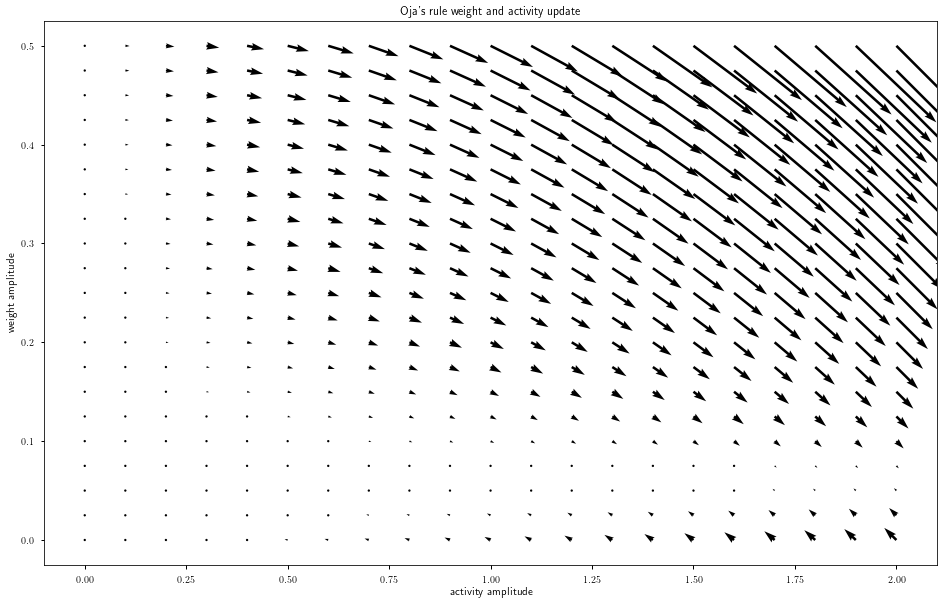

In [39]:
_lambda=N/2
plt.figure(figsize=(16,10))
phase_plot(np.linspace(0,2,21), np.linspace(0,0.5,21), instantaneous_grad_a_W)
plt.xlabel('activity amplitude')
plt.ylabel('weight amplitude')
plt.title('Oja\'s rule weight and activity update')
plt.show()

This looks like a line attractor - the weights are always driven to a particular value, but the activity could be driven to any value.

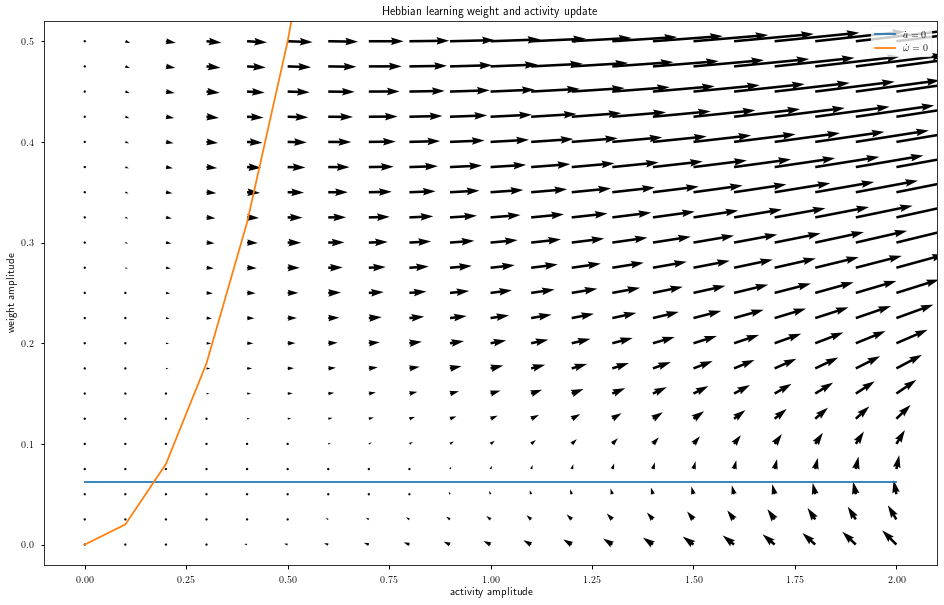

In [48]:
gamma = 3 / 4 * v_magnitude**2
_lambda = 1/4*N*v_magnitude**2
plt.figure(figsize=(16,10))
x_range = np.linspace(0,2,21)
y_range = np.linspace(0,0.5,21)
phase_plot(x_range, y_range, Hebbian_instantaneous_grad_a_W)
plt.plot(x_range, 2/N*np.ones_like(y_range), label='$\\dot a = 0$')
plt.plot(x_range, x_range**2/_lambda, label='$\\dot \\omega = 0$')
plt.ylim([y_range[0]-0.02, y_range[-1]+0.02])
plt.xlabel('activity amplitude')
plt.ylabel('weight amplitude')
plt.title('Hebbian learning weight and activity update')
plt.legend()
plt.show()

This looks like a saddle